In [ ]:
# !pip install -q  torchtext
# !pip install -qU torch
# !pip install -qq transformers
# !pip install -q inflect
# !pip install -q nltk

In [2]:
!nvidia-smi

Mon Aug 30 18:46:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.118.02   Driver Version: 440.118.02   CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  On   | 00000000:51:00.0 Off |                  N/A |
|  0%   32C    P8     9W / 250W |   5239MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  On   | 00000000:CB:00.0 Off |                  N/A |
| 55%   67C    P0    84W / 250W |     12MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [3]:
from __future__ import unicode_literals, print_function

import numpy as np
import pandas as pd
import random

import os
import re

import inflect
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, random_split
from transformers import AdamW
from transformers import BertForSequenceClassification, BertTokenizer
from torchtext.legacy import data

from tqdm.notebook import tqdm

from contextlib import closing
from multiprocessing import Pool
import matplotlib.pyplot as plt
from IPython.display import Image

In [4]:
TRAIN_TEST_RATIO = 0.2


ROOT_DATA_PATH = 'data/SST-2'
TRAIN_FILE = os.path.join(ROOT_DATA_PATH, 'train.tsv')
TEST_FILE = os.path.join(ROOT_DATA_PATH, 'test.tsv')
DEV_FILE = os.path.join(ROOT_DATA_PATH, 'dev.tsv')
LOG_DIR = os.path.join(ROOT_DATA_PATH, 'logs')


bert_settings = {
    'max_seq_length': 128,
    'num_train_epochs': 10,
    'train_batch_size': 64,
    'val_batch_size': 32,
    'learning_rate': 1e-5,
    'adam_epsilon': 1e-8,
    'test_size': TRAIN_TEST_RATIO,
    'log_dir': LOG_DIR,
    'tb_suffix': 'bert'
}

lstm_settings = {
    'max_seq_length': 128,
    'num_train_epochs': 30,
    'train_batch_size': 64,
    'val_batch_size': 32,
    'test_size': TRAIN_TEST_RATIO,
    'log_dir': LOG_DIR,
    'tb_suffix': 'lstm'
}

distillation_settings = {
    'max_seq_length': 128,
    'num_train_epochs': 30,
    'train_batch_size': 64,
    'val_batch_size': 32,
    'test_size': TRAIN_TEST_RATIO,
    'log_dir': LOG_DIR,
    'tb_suffix': 'd_lstm'
}

# Our Task:
glue/sst2

Config description: The Stanford Sentiment Treebank consists of sentences from movie reviews and human annotations of their sentiment. The task is to predict the sentiment of a given sentence. We use the two-way (positive/negative) class split, and use only sentence-level labels.

Homepage: https://nlp.stanford.edu/sentiment/index.html
```
{
    'idx': int,
    'label': num_classes=2, 1-> positive and 0-> negative.
    'sentence': Text,
}
```

In [5]:
def device():
    return torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [6]:
def pad(seq, max_len):
    if len(seq) < max_len:
        seq = seq + ['<pad>'] * (max_len - len(seq))
    return seq[0:max_len]

In [7]:
def to_indexes(vocab, words):
    return [vocab.stoi[w] for w in words]

In [8]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(0)

In [9]:
class SimpleLSTM(nn.Module):

    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers,
                 bidirectional, dropout, batch_size, device=None):
        super(SimpleLSTM, self).__init__()
        
        # define our parameters
        self.batch_size = batch_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        # define our main layers.
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.LSTM(self.embedding.embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional) #, dropout=dropout
        self.fc = nn.Linear(hidden_dim * 2, output_dim) #
        
        self.dropout = nn.Dropout(dropout)
        self.device = self.init_device(device)

    @staticmethod
    def init_device(device):
        if device is None:
            return torch.device('cuda:2')
        return device

    def forward(self, text, text_lengths=None):
        x = self.embedding(text)
        x, (hidden, cell) = self.rnn(x)
        # concatinating the forward and backword hidden. (BILSTM)
        hidden = self.dropout(torch.cat((hidden[0, :, :], hidden[1, :, :]), dim=1))
        x = self.fc(hidden)
        return x

as we will train more than one model, it's better to build a simple framework to help us not duplicating the code.

In [10]:
class Trainer(object):
    """
    A class used to represent our Traingin class.

    Attributes
    ----------
    setting : the main setting of the underline model.
        hold the hyperbarameters of the model and the training parameters.

    Methods
    -------
    __init__:
        define our Attributes
    print_epoch:
        print traingin epoch information.
    """
    def __init__(self, settings):
        self.settings = settings
        self.train_losses= []
        self.eval_losses= []

    def log_epoch(self, train_loss, eval_loss, acc, epoch):
        print("epoch={}: train_loss={:.4f}, val_loss={:.4f}, acc={:.4f}".format(epoch, train_loss, eval_loss, acc))
        self.train_losses.append(train_loss)
        self.eval_losses.append(eval_loss)
    
    def plot_training(self):
        p_count = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        print('\n Number of Trainable Params {}'.format(p_count))
        plt.plot(range(self.settings['num_train_epochs']), self.train_losses, label="sine")
        plt.plot(range(self.settings['num_train_epochs']), self.eval_losses, label="sine")

In [11]:
def remove_punctuation(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

In [12]:
def replace_numbers(words):
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

In [13]:
def stem_words(words):
    stemmer = SnowballStemmer('english')
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

In [14]:
def normalize(words):
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = stem_words(words)
    return words

In [15]:
class LSTMTrainer(Trainer):
    
    def to_tensor(self, x, y, y_real):
        torch_x = torch.tensor(x, dtype=torch.long)
        torch_y = torch.tensor(y, dtype=torch.float)
        torch_real_y = torch.tensor(y_real, dtype=torch.long)
        return TensorDataset(torch_x, torch_y, torch_real_y)

    def to_device(self, text, bert_prob, real_label):
        text = text.to(device())
        bert_prob = bert_prob.to(device())
        real_label = real_label.to(device())
        return text, bert_prob, real_label
    
    def train(self, X, y, y_real, output_dir):

        X_split = [normalize(t.split()) for t in X]

        X_train, X_test, y_train, y_test, y_real_train, y_real_test = train_test_split(X_split, y, y_real, test_size=self.settings['test_size'], stratify=y_real)

        text_field = data.Field()
        text_field.build_vocab(X_train, max_size=10000)

        # pad
        X_train_pad = [pad(s, self.settings['max_seq_length']) for s in X_train]
        X_test_pad = [pad(s, self.settings['max_seq_length']) for s in X_test]

        # to index
        X_train_index = [to_indexes(text_field.vocab, s) for s in X_train_pad]
        X_test_index = [to_indexes(text_field.vocab, s) for s in X_test_pad]
        
        #get tensors
        train_dataset = self.to_tensor(X_train_index, y_train, y_real_train)
        val_dataset = self.to_tensor(X_test_index, y_test, y_real_test)

        self.model = self.build_model(text_field)
        self.model.to(device())
        
        self.full_train(train_dataset, val_dataset, output_dir)
        torch.save(text_field, os.path.join(output_dir, type(self).__name__ + 'vocab.pt'))

        return self.model, text_field.vocab


    
    def full_train(self, train_dataset, val_dataset, output_dir):
        num_train_epochs = self.settings['num_train_epochs']
        best_val_loss = 100000
        for epoch in range(num_train_epochs):
            # training
            train_loss = 0
            train_sampler = RandomSampler(train_dataset)
            train_data_loader = DataLoader(train_dataset, sampler=train_sampler, batch_size=self.settings['train_batch_size'], drop_last=True)
            self.model.train()
            num_examples = 0
            optimizer, scheduler = self.optimizer(self.model)
            for i, (text, bert_prob, real_label) in enumerate(tqdm(train_data_loader, desc='Train', leave=False)):
                text, bert_prob, real_label = self.to_device(text, bert_prob, real_label)
                self.model.zero_grad()
                output = self.model(text.t()).squeeze(1)
                loss = self.loss(output, bert_prob, real_label)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                num_examples += len(real_label)
            scheduler.step()
            train_loss /= num_examples

            # validation
            val_sampler = SequentialSampler(val_dataset)
            val_data_loader = DataLoader(val_dataset, sampler=val_sampler, batch_size=self.settings['val_batch_size'], drop_last=True)

            val_loss = 0.0
            val_acc = 0.0
            num_examples = 0
            self.model.eval()
            for i, (text, bert_prob, real_label) in enumerate(tqdm(val_data_loader, desc='Val', leave=False)):
                text, bert_prob, real_label = self.to_device(text, bert_prob, real_label)
                output = self.model(text.t()).squeeze(1)

                loss = self.loss(output, bert_prob, real_label)
                val_loss += loss.item()

                probs = torch.softmax(output, dim=1)
                pred_label = torch.argmax(probs, dim=1)
                val_acc += torch.sum(pred_label == real_label).cpu().numpy()
                num_examples += len(real_label)
            
            val_loss /= num_examples
            val_acc /= num_examples
            
            self.log_epoch(train_loss, val_loss, val_acc, epoch)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                print('Update Best Model @ Epoch: {} With Validation Loss: {:.4f}'.format(epoch, val_loss))
                torch.save(self.model.state_dict(), os.path.join(output_dir, type(self).__name__ + 'weights.pt'))
        self.plot_training()
    
    def loss(self, output, bert_prob, real_label):
        raise NotImplementedError()
    
    def build_model(self, text_field):
        raise NotImplementedError()
    
    def optimizer(self, model):
        raise NotImplementedError()

In [16]:
class BILSTMStudentTrainer(LSTMTrainer):
    """
    LSTM baseline
    """

    def __init__(self, settings):
        super(BILSTMStudentTrainer, self).__init__(settings)
        self.criterion = torch.nn.CrossEntropyLoss()

    def loss(self, output, bert_prob, real_label):
        return self.criterion(output, real_label)
    
    def optimizer(self, model):
        optimizer = torch.optim.Adam(model.parameters())
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)
        return optimizer, scheduler
    
    def build_model(self, text_field):
        model = SimpleLSTM( input_dim=len(text_field.vocab),
                           embedding_dim=16,
                           hidden_dim=8, output_dim=2,
                           n_layers=1, dropout=0.5,
                           bidirectional=True,
                           batch_size=self.settings['train_batch_size'])
        return model

Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=0: train_loss=0.0106, val_loss=0.0205, acc=0.6089
Update Best Model @ Epoch: 0 With Validation Loss: 0.0205


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=1: train_loss=0.0094, val_loss=0.0164, acc=0.7484
Update Best Model @ Epoch: 1 With Validation Loss: 0.0164


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=2: train_loss=0.0076, val_loss=0.0137, acc=0.8015
Update Best Model @ Epoch: 2 With Validation Loss: 0.0137


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=3: train_loss=0.0065, val_loss=0.0121, acc=0.8315
Update Best Model @ Epoch: 3 With Validation Loss: 0.0121


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=4: train_loss=0.0058, val_loss=0.0109, acc=0.8516
Update Best Model @ Epoch: 4 With Validation Loss: 0.0109


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=5: train_loss=0.0052, val_loss=0.0102, acc=0.8615
Update Best Model @ Epoch: 5 With Validation Loss: 0.0102


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=6: train_loss=0.0047, val_loss=0.0096, acc=0.8744
Update Best Model @ Epoch: 6 With Validation Loss: 0.0096


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=7: train_loss=0.0044, val_loss=0.0091, acc=0.8835
Update Best Model @ Epoch: 7 With Validation Loss: 0.0091


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=8: train_loss=0.0041, val_loss=0.0088, acc=0.8898
Update Best Model @ Epoch: 8 With Validation Loss: 0.0088


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=9: train_loss=0.0039, val_loss=0.0086, acc=0.8932
Update Best Model @ Epoch: 9 With Validation Loss: 0.0086


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=10: train_loss=0.0037, val_loss=0.0085, acc=0.8975
Update Best Model @ Epoch: 10 With Validation Loss: 0.0085


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=11: train_loss=0.0035, val_loss=0.0082, acc=0.8990
Update Best Model @ Epoch: 11 With Validation Loss: 0.0082


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=12: train_loss=0.0033, val_loss=0.0084, acc=0.9006


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=13: train_loss=0.0032, val_loss=0.0082, acc=0.9045


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=14: train_loss=0.0031, val_loss=0.0080, acc=0.9042
Update Best Model @ Epoch: 14 With Validation Loss: 0.0080


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=15: train_loss=0.0030, val_loss=0.0079, acc=0.9054
Update Best Model @ Epoch: 15 With Validation Loss: 0.0079


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=16: train_loss=0.0029, val_loss=0.0078, acc=0.9096
Update Best Model @ Epoch: 16 With Validation Loss: 0.0078


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=17: train_loss=0.0028, val_loss=0.0078, acc=0.9112
Update Best Model @ Epoch: 17 With Validation Loss: 0.0078


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=18: train_loss=0.0027, val_loss=0.0081, acc=0.9101


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=19: train_loss=0.0026, val_loss=0.0079, acc=0.9163


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=20: train_loss=0.0025, val_loss=0.0079, acc=0.9149


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=21: train_loss=0.0025, val_loss=0.0079, acc=0.9156


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=22: train_loss=0.0024, val_loss=0.0079, acc=0.9161


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=23: train_loss=0.0023, val_loss=0.0080, acc=0.9174


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=24: train_loss=0.0023, val_loss=0.0080, acc=0.9190


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=25: train_loss=0.0022, val_loss=0.0080, acc=0.9175


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=26: train_loss=0.0022, val_loss=0.0082, acc=0.9196


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=27: train_loss=0.0021, val_loss=0.0081, acc=0.9201


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=28: train_loss=0.0021, val_loss=0.0083, acc=0.9213


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=29: train_loss=0.0020, val_loss=0.0082, acc=0.9218

 Number of Trainable Params 161730


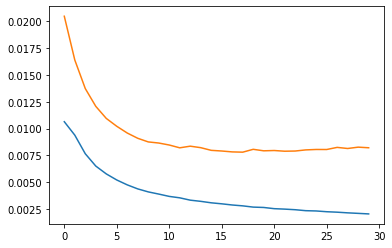

In [17]:
train_df = pd.read_csv(TRAIN_FILE, encoding='utf-8', sep='\t')
X_train  = train_df['sentence'].values
y_train  = train_df['label'].values

trainer = BILSTMStudentTrainer(lstm_settings)
model, vocab = trainer.train(X_train, y_train, y_train, ROOT_DATA_PATH)

# Fine Tuning BERT

# BERT

[BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)

**Google AI Language**

Jacob Devlin, Ming-Wei Chang, Kenton Lee, Kristina Toutanova

**11 Oct 2018**

### Abstract

BERT is a new language representation model, which stands for $\color{blue}{\text{Bidirectional Encoder Representations from Transformers}}$. 

Unlike recent language representation models, BERT is designed to pre-train deep **bidirectional representations** from unlabeled text by jointly conditioning on both left and right context in all layers. 

As a result, the pre-trained BERT model can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial task-specific architecture modifications. 


BERT is conceptually simple and empirically powerful. It obtains new state-of-the-art results on eleven natural language processing tasks, 
including pushing the GLUE score to 80.5% (7.7% point absolute improvement), MultiNLI accuracy to 86.7% (4.6% absolute improvement), 
SQuAD v1.1 question answering Test F1 to 93.2 (1.5 point absolute improvement) and SQuAD v2.0 Test F1 to 83.1 (5.1 point absolute improvement).



## Model Architecture

BERT's model architecture is a $\color{blue}{\text{multi-layer bidirectional Transformer Encoder}}$.

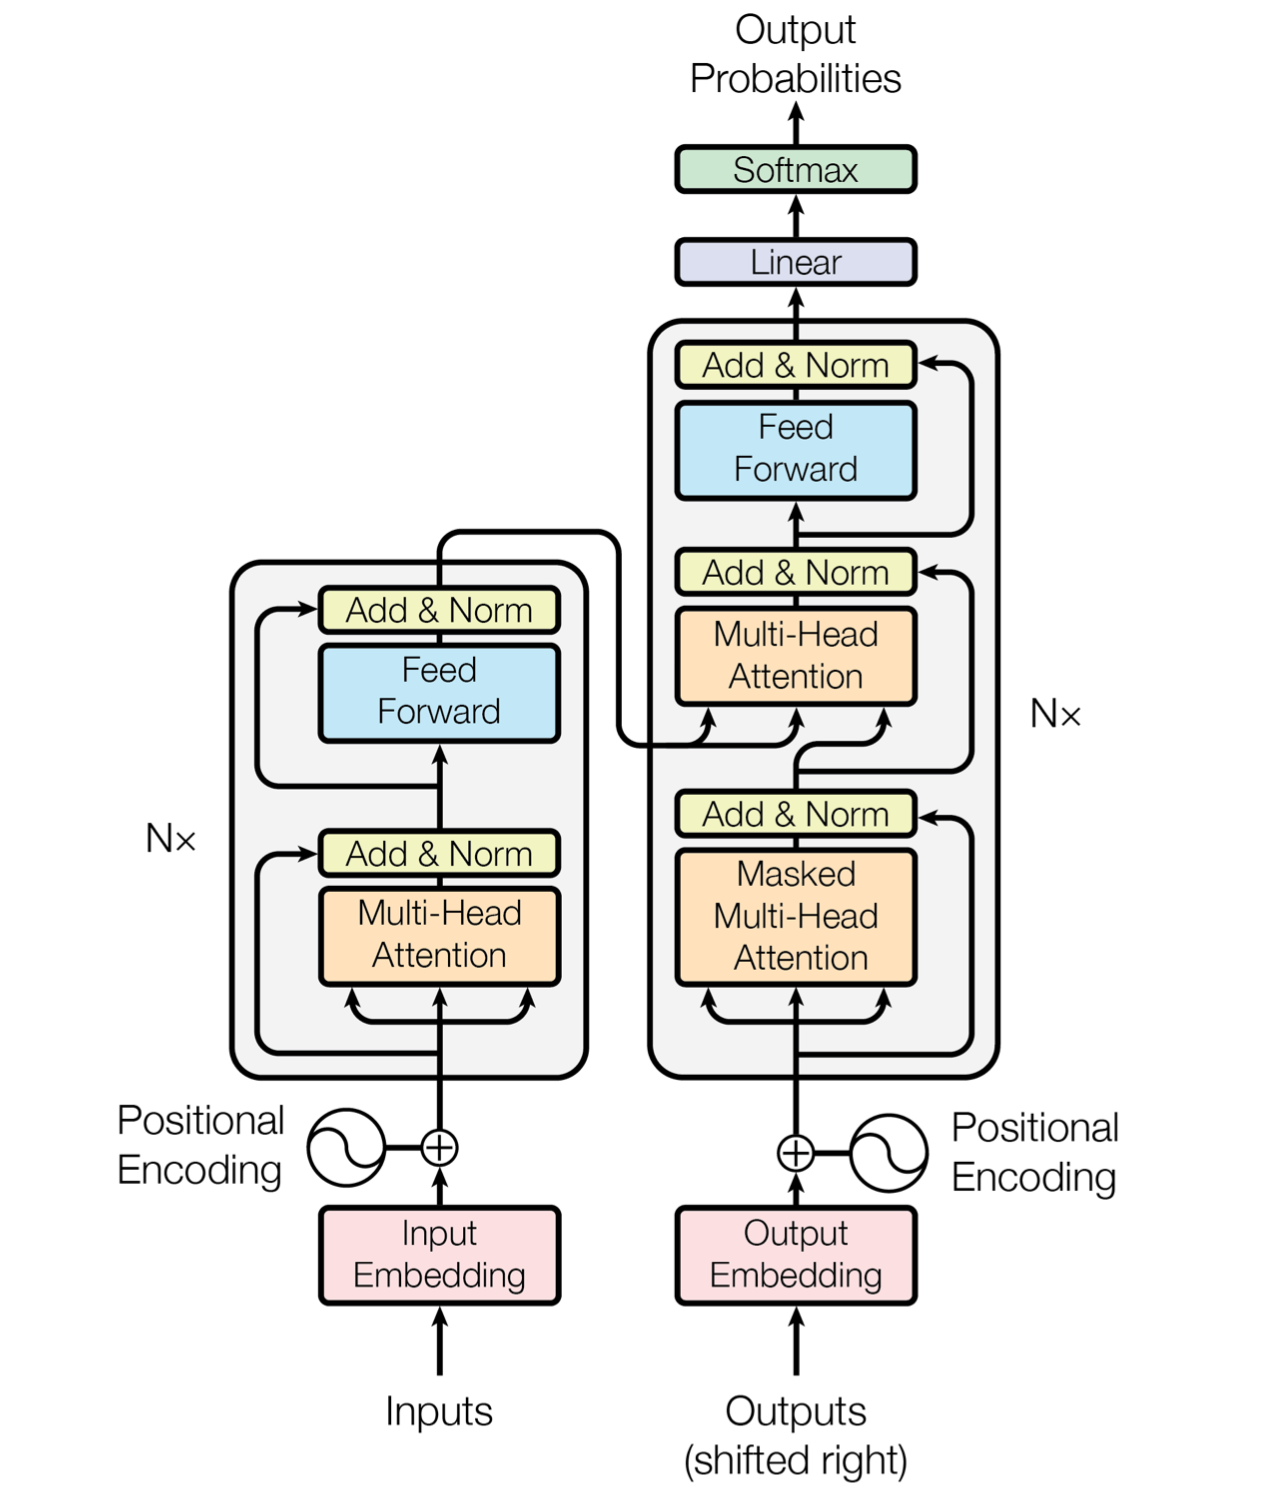

In [18]:
Image(filename='data/Images/Transformer.png', width=500, height=500)

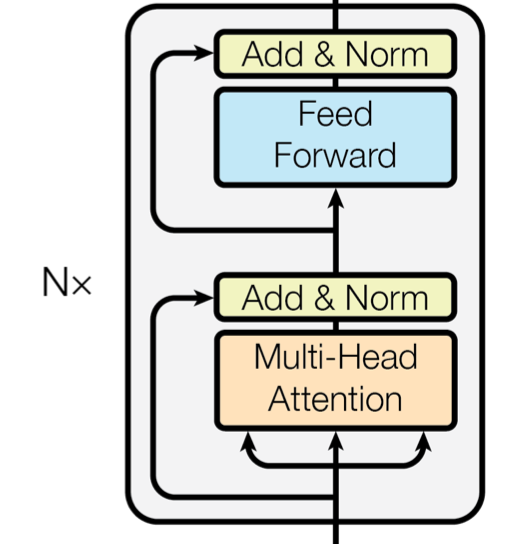

In [19]:
Image(filename='data/Images/Transformer-Encoder.png', width=400, height=400)

## Pre-training BERT

We do not use traditional left-to-right or right-to-left language models to pre-train BERT. Instead, we pre-train BERT using two unsupervised tasks:

### Masked LM

Intuitively, it is reasonable to believe that a deep bidirectional model is strictly more powerful than either a left-to-right model 
or the shallow concatenation of a left-to-right and a right-to-left model. 
Unfortunately, standard conditional language models can only be trained left-to-right or right-to-left, since bidirectional conditioning 
would allow each word to indirectly “see itself”, and the model could trivially predict the target word in a multi-layered context.

**Cloze task:**
In order to train a deep **bidirectional** representation, we simply **mask** some percentage (15%) of the input tokens at random, and then predict those masked tokens.
In all experiments, we mask 15% of all WordPiece tokens in each sequence at random. In contrast to denoising auto-encoders, we only predict the masked words rather than reconstructing the entire input.
Although this allows us to obtain a bidirectional pre-trained model, a downside is that we are creating a mismatch between 
pre-training and fine-tuning, since the $[\text{MASK}]$ token does not appear during fine-tuning. 
To mitigate this, we **do not always replace** “masked” words with the actual $[\text{MASK}]$ token. 

The training data generator chooses 15% of the token positions at random for prediction. If the i-th token is chosen, we replace the i-th token with 
 - **(1).** the $[\text{MASK}]$ token 80% of the time 
 - **(2).** a random token 10% of the time 
 - **(3).** the unchanged i-th token 10% of the time.

### Next Sentence Prediction (NSP)

In order to train a model that understands sentence relationships, they pre-trained for a binarized next sentence prediction task that can be trivially 
generated from any monolingual corpus. 
Specifically, when choosing the sentences **A** and **B** for each pretraining example, 50% of the time **B** is the actual next sentence 
that follows **A** (labeled as IsNext), and 50% of the time it is a random sentence from the corpus (labeled as NotNext).


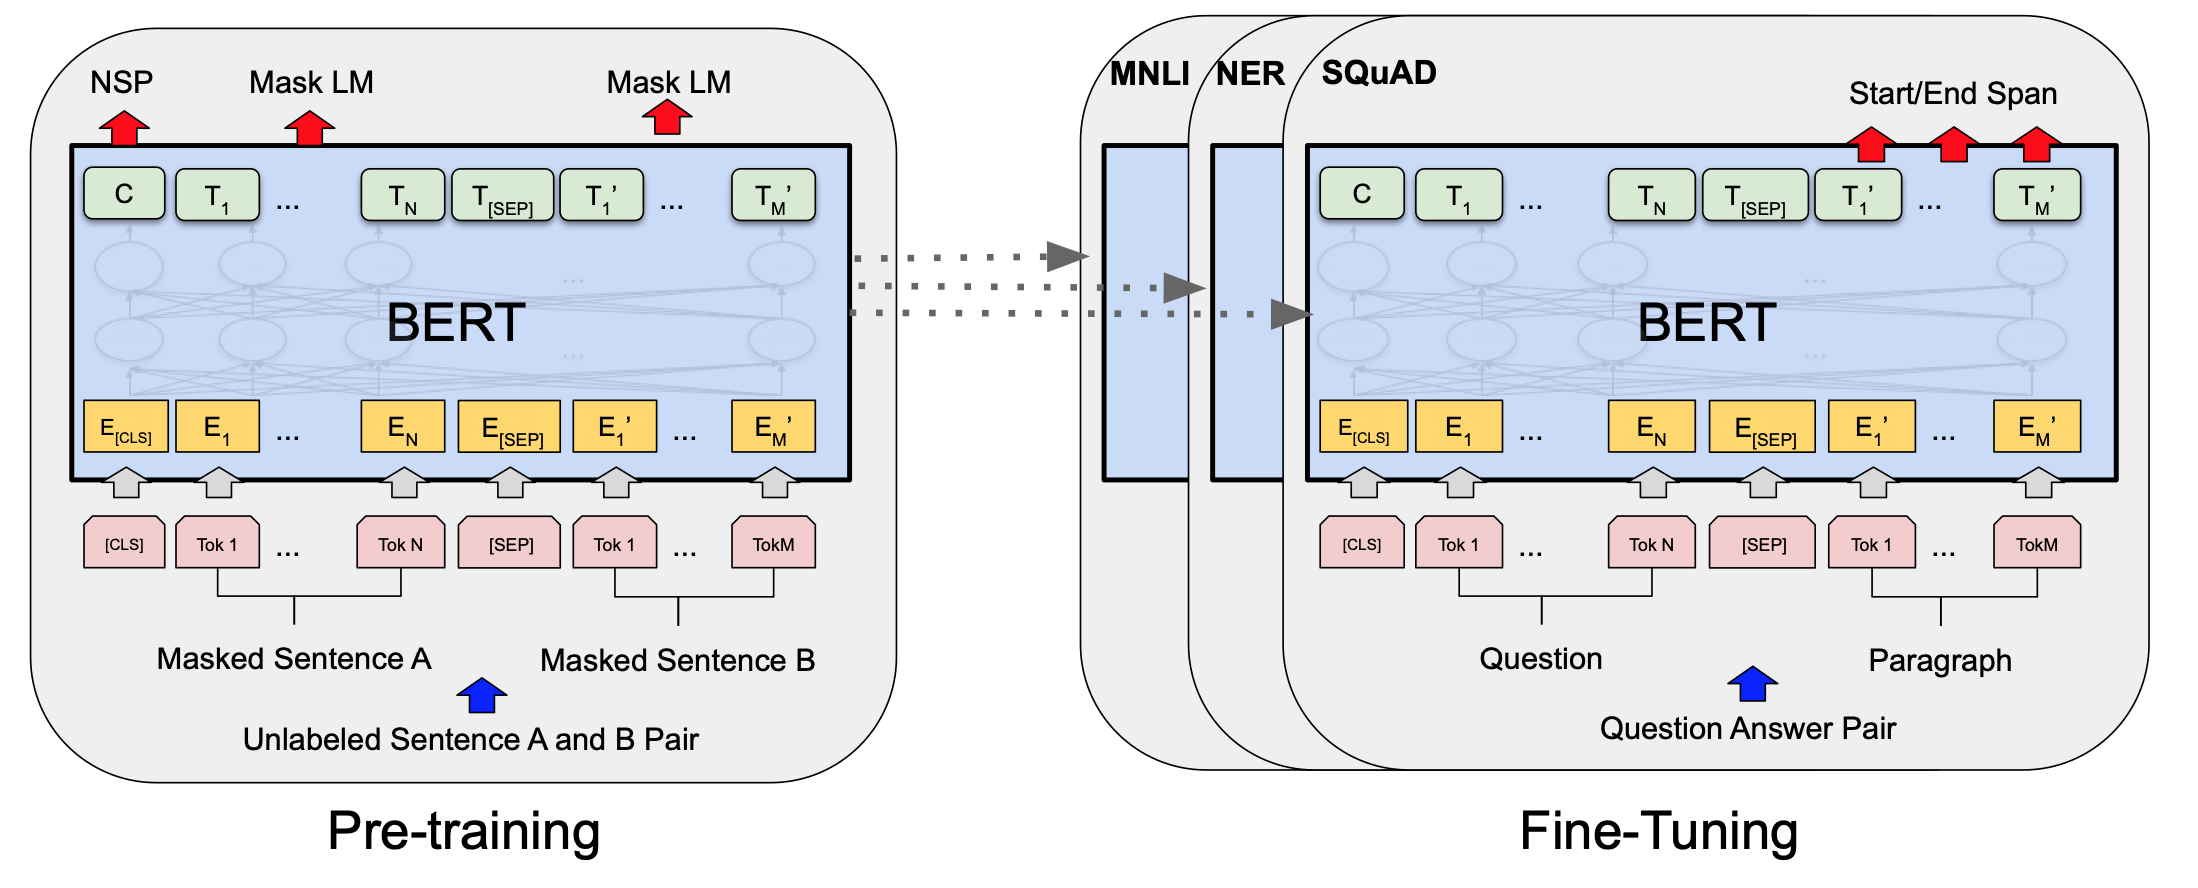

In [20]:
Image(filename='data/Images/BERT+Fine-Tuning.png', width=900, height=400)

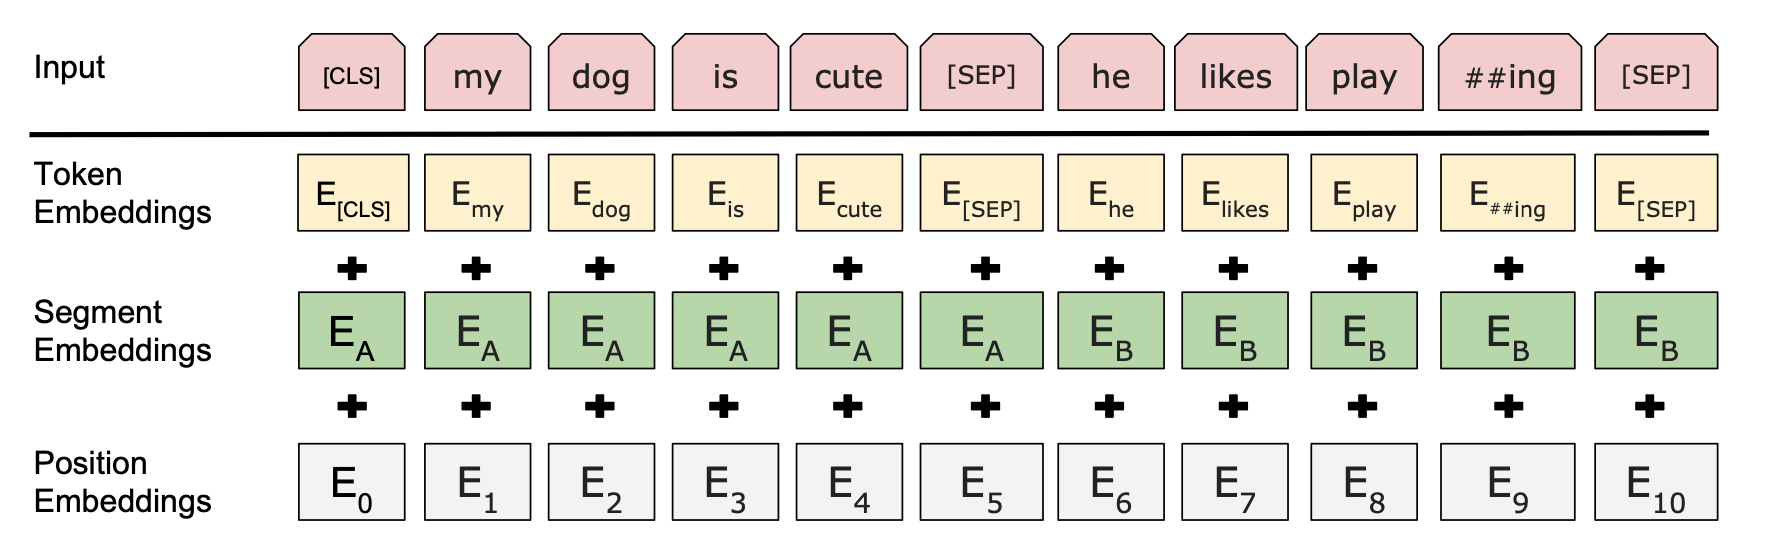

In [21]:
Image(filename='data/Images/BERT+embeddings.png', width=900, height=350)

## Fine-tuning BERT

For each task, we simply plug in the task- specific inputs and outputs into BERT and fine-tune all the parameters **end-to-end**. 

At the input, sentence A and sentence B from pre-training are analogous to 

**(1)** sentence pairs in paraphrasing, 

**(2)** hypothesis-premise pairs in entailment, 

**(3)** question-passage pairs in question answering, and

**(4)** a degenerate text-$\emptyset$ pair in text classification or sequence tagging. 

At the output, the token representations are fed into an output layer for token-level tasks, such as sequence tagging or question answering, 
and the $\text{[CLS]}$ representation is fed into an output layer for classification, such as entailment or sentiment analysis.

In [22]:
class InputExample(object):
    """
    A single training/test example for sequence classification.
    """
    def __init__(self, text_a, label=None):
        self.text_a = text_a
        self.label = label

In [23]:
class InputFeatures(object):
    """
    A single set of features of data.
    """

    def __init__(self, input_ids, input_mask, segment_ids, label_ids):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_ids = label_ids

In [24]:
def build_feature(data_row):
    """Building our input feature.

    this function build input feature to BERT model,
    first trim the input so the length of it is max_seq_length -2. 2 are for [CLS] and [SEP] tokens
    The mask has 1 for real tokens and 0 for padding tokens.
    segment id are zeros as we have just one segment.

    input=        [     word,  word,  ...,  word ]
    input=        [     token, token, ...,  token]
    tokens=       [CLS, token, token, ...,  token, SEP, 0, 0, 0, ...]
    input_ids=    [1  , 45   , 86   , ...,  34   , 2  , 0, 0, 0, ...]
    input_mask =  [1  , 1  ,   1    , ...,  1    , 1  , 0, 0, 0, ...]
    segment_ids=  [0  , 0  ,   0    , ...,  0    , 0  , 0, 0, 0, ...]


    Args:
        data_row (tuple): sampel from the dataset.

    Returns:
        InputFeatures object formed from our lists of tokens.
    """

    (example, label_map, tokenizer, max_seq_length) = data_row

    try:
        tokens = tokenizer.tokenize(example.text_a)
    except Exception as e:
        tokens = []

    # - 2 for CLS and SEP with
    if len(tokens) > max_seq_length - 2:
        tokens = tokens[:(max_seq_length - 2)]

    tokens = [tokenizer.cls_token] + tokens + [tokenizer.sep_token]
    segment_ids = [0] * len(tokens)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_mask = [1] * len(input_ids)

    # padding.
    padding_length = max_seq_length - len(input_ids)

    input_ids = input_ids + ([0] * padding_length)
    input_mask = input_mask + ([0] * padding_length)
    segment_ids = segment_ids + ([0] * padding_length)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    # get the label 0,1.
    label_id = label_map[example.label]

    return InputFeatures(input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids, label_ids=label_id)


In [25]:
def features_to_tensor(features):
    """
    build torch tensor out of input feature.
    """
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_ids for f in features], dtype=torch.long)

    dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
    return dataset

In [26]:
def df_to_dataset(df, tokenizer, max_seq_length):
    bert_df = pd.DataFrame({
        'id': range(len(df)),
        'label': df['label'],
        'text': df['sentence'].replace(r'\n', ' ', regex=True)
    })
    examples = []
    for (i, line) in enumerate(bert_df.T.to_dict().values()):
        text_a = line['text']
        label = line['label']
        examples.append(InputExample(text_a=text_a, label=label))

    label_map = {label: i for i, label in enumerate([0, 1])} #{0: 0, 1: 1}
    examples = [(example, label_map, tokenizer, max_seq_length) for example in examples]

    with closing(Pool(10)) as p:
        features = list(tqdm(p.imap(build_feature, examples, chunksize=100), total=len(examples)))
        p.terminate()

    return features_to_tensor(features)

In [27]:
train_df = pd.read_csv(TRAIN_FILE, encoding='utf-8', sep='\t')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = df_to_dataset(train_df, bert_tokenizer, bert_settings['max_seq_length'])

  0%|          | 0/67349 [00:00<?, ?it/s]

In [28]:
def batch_to_inputs(batch):
    inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'token_type_ids': batch[2],'labels': batch[3]}
    return inputs

In [29]:
class BertTrainer(Trainer):

    def train(self, train_dataset, tokenizer, output_dir):
        model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
        model.to(device())
        self.full_train(train_dataset, model, tokenizer, output_dir)
        return model

    def optimizer(self, model):

        train_settings = self.settings

        optimizer = AdamW(model.parameters(), lr=train_settings['learning_rate'],
                          eps=train_settings['adam_epsilon'])
        return optimizer

    def full_train(self, dataset, model, tokenizer, output_dir):

        train_settings = self.settings

        val_len = int(len(dataset) * train_settings['test_size'])
        train_dataset, val_dataset = random_split(dataset, (len(dataset)-val_len, val_len))

        optimizer = self.optimizer(model)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

        model.zero_grad()

        for epoch in range(int(train_settings['num_train_epochs'])):
            train_loss = 0.0

            train_sampler = RandomSampler(train_dataset)
            train_data_loader = DataLoader(train_dataset, sampler=train_sampler, batch_size=self.settings['train_batch_size'])

            for step, batch in enumerate(tqdm(train_data_loader, desc="Iteration", leave=False)):
                model.train()
                batch = tuple(t.to(device()) for t in batch)
                inputs = batch_to_inputs(batch)
                outputs = model(**inputs)
                loss = outputs[0]
                loss.backward()
                train_loss += loss.item()

                optimizer.step()
                model.zero_grad()

            scheduler.step()
            train_loss /= len(train_data_loader)
            
            val_sampler = SequentialSampler(val_dataset)
            val_data_loader = DataLoader(val_dataset, sampler=val_sampler, batch_size=self.settings['val_batch_size'])

            val_loss = 0.0
            val_acc = 0.0
            num_examples = 0
            model.eval()
            for batch in tqdm(val_data_loader, desc="valuating", leave=False):
                batch = tuple(t.to(device()) for t in batch)

                with torch.no_grad():
                    inputs = batch_to_inputs(batch)
                    outputs = model(**inputs)
                    tmp_val_loss, logits = outputs[:2]

                    val_loss += tmp_val_loss.item()

                    probs = torch.softmax(logits, dim=1)
                    pred_label = torch.argmax(logits, dim=1)
                    val_acc += torch.sum(pred_label == batch[3]).cpu().numpy()
                    num_examples += len(batch[3])

            val_loss /= len(val_data_loader)
            val_acc /= num_examples

            self.log_epoch(train_loss, val_loss, val_acc, epoch)

            model.save_pretrained(output_dir)

In [30]:
trainer = BertTrainer(bert_settings)
model = trainer.train(train_dataset, bert_tokenizer, ROOT_DATA_PATH)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Iteration:   0%|          | 0/842 [00:00<?, ?it/s]

valuating:   0%|          | 0/421 [00:00<?, ?it/s]

epoch=0: train_loss=0.2528, val_loss=0.1644, acc=0.9385


Iteration:   0%|          | 0/842 [00:00<?, ?it/s]

valuating:   0%|          | 0/421 [00:00<?, ?it/s]

epoch=1: train_loss=0.1366, val_loss=0.1455, acc=0.9490


Iteration:   0%|          | 0/842 [00:00<?, ?it/s]

valuating:   0%|          | 0/421 [00:00<?, ?it/s]

epoch=2: train_loss=0.0962, val_loss=0.1467, acc=0.9523


Iteration:   0%|          | 0/842 [00:00<?, ?it/s]

valuating:   0%|          | 0/421 [00:00<?, ?it/s]

epoch=3: train_loss=0.0709, val_loss=0.1635, acc=0.9506


Iteration:   0%|          | 0/842 [00:00<?, ?it/s]

valuating:   0%|          | 0/421 [00:00<?, ?it/s]

epoch=4: train_loss=0.0542, val_loss=0.1723, acc=0.9525


Iteration:   0%|          | 0/842 [00:00<?, ?it/s]

valuating:   0%|          | 0/421 [00:00<?, ?it/s]

epoch=5: train_loss=0.0437, val_loss=0.1822, acc=0.9518


Iteration:   0%|          | 0/842 [00:00<?, ?it/s]

valuating:   0%|          | 0/421 [00:00<?, ?it/s]

epoch=6: train_loss=0.0344, val_loss=0.2059, acc=0.9500


Iteration:   0%|          | 0/842 [00:00<?, ?it/s]

valuating:   0%|          | 0/421 [00:00<?, ?it/s]

epoch=7: train_loss=0.0282, val_loss=0.2203, acc=0.9502


Iteration:   0%|          | 0/842 [00:00<?, ?it/s]

valuating:   0%|          | 0/421 [00:00<?, ?it/s]

epoch=8: train_loss=0.0227, val_loss=0.2353, acc=0.9507


Iteration:   0%|          | 0/842 [00:00<?, ?it/s]

valuating:   0%|          | 0/421 [00:00<?, ?it/s]

epoch=9: train_loss=0.0193, val_loss=0.2459, acc=0.9498


In [31]:
# 1. get data
train_df = pd.read_csv(TRAIN_FILE, encoding='utf-8', sep='\t')

bert_model = BertForSequenceClassification.from_pretrained(ROOT_DATA_PATH)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_dataset = df_to_dataset(train_df, tokenizer, distillation_settings['max_seq_length'])
sampler = SequentialSampler(train_dataset)
train_loader = DataLoader(train_dataset, sampler=sampler, batch_size=distillation_settings['train_batch_size'])

bert_model.to(device())
bert_model= bert_model.eval()

  0%|          | 0/67349 [00:00<?, ?it/s]

In [32]:
# get the logits of bert and save them in bert_logits
bert_logits = None
for batch in tqdm(train_loader, desc="bert logits"):
    batch = tuple(t.to(device()) for t in batch)
    inputs = batch_to_inputs(batch)

    with torch.no_grad():
        outputs = bert_model(**inputs)
        _, logits = outputs[:2]

        logits = logits.cpu().numpy()
        if bert_logits is None:
            bert_logits = logits
        else:
            bert_logits = np.vstack((bert_logits, logits))

bert logits:   0%|          | 0/1053 [00:00<?, ?it/s]

https://arxiv.org/abs/1903.12136

The distillation approach accomplishes knowledge transfer at the output level; that is, the student network learns to mimic a teacher network’s behavior given any data point. In addition to a one-hot predicted label, the teacher’s predicted probability is also important. In binary sentiment classification, for example, some sentences have a strong sentiment polarity, whereas others appear neutral.
If we use only the teacher’s predicted one-hot label to train the student, we may lose valuable information about the prediction uncertainty.

The distillation objective is to penalize the mean-squared-error (MSE) loss between the student network’s logits against the teacher’s logits:

$L_{distill} = ||z^{(B)} - z^{(B)}||_2^2 $


where $z^{(B)}$ and $z^{(B)}$ are the teacher’s and student’s logits, respectively. 
They found that MSE perform slightly better than cross entropy with soft targets.
At training time, the distilling objective can be used in conjunction with a traditional cross-entropy loss against a one-hot label t, given by

$L= \alpha * L_{CE} + (1 − \alpha) * L_{distill} = − \alpha \sum_{i} t_i log y_i^{(S)} − (1 − \alpha)||z^{(B)} - z^{(B)}||_2^2$

When distilling with a labeled dataset, the one-hot target t is simply the ground-truth label. When distilling with an unlabeled dataset, we use the
predicted label by the teacher

In [33]:
# LSTM Distilled Student
class BILSTMDistilledStudentTrainer(LSTMTrainer):
    def __init__(self, settings):
        super(BILSTMDistilledStudentTrainer, self).__init__(settings)
        self.criterion_mse = torch.nn.MSELoss()
        self.criterion_ce = torch.nn.CrossEntropyLoss()
        self.a = 0.5

    def loss(self, output, bert_prob, real_label):
        return self.a * self.criterion_ce(output, real_label) + (1 - self.a) * self.criterion_mse(output, bert_prob)
    
    def optimizer(self, model):
        optimizer = torch.optim.Adam(model.parameters())
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)
        return optimizer, scheduler
    
    def build_model(self, text_field):
        model = SimpleLSTM(
            input_dim=len(text_field.vocab),
            embedding_dim=16,
            hidden_dim=8,
            output_dim=2,
            n_layers=1,
            bidirectional=True,
            dropout=0.5,
            batch_size=self.settings['train_batch_size'])
        return model

Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=0: train_loss=0.1424, val_loss=0.2491, acc=0.6879
Update Best Model @ Epoch: 0 With Validation Loss: 0.2491


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=1: train_loss=0.1119, val_loss=0.1914, acc=0.7735
Update Best Model @ Epoch: 1 With Validation Loss: 0.1914


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=2: train_loss=0.0905, val_loss=0.1567, acc=0.8152
Update Best Model @ Epoch: 2 With Validation Loss: 0.1567


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=3: train_loss=0.0763, val_loss=0.1329, acc=0.8447
Update Best Model @ Epoch: 3 With Validation Loss: 0.1329


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=4: train_loss=0.0676, val_loss=0.1190, acc=0.8617
Update Best Model @ Epoch: 4 With Validation Loss: 0.1190


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=5: train_loss=0.0611, val_loss=0.1081, acc=0.8728
Update Best Model @ Epoch: 5 With Validation Loss: 0.1081


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=6: train_loss=0.0567, val_loss=0.1006, acc=0.8829
Update Best Model @ Epoch: 6 With Validation Loss: 0.1006


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=7: train_loss=0.0526, val_loss=0.0947, acc=0.8906
Update Best Model @ Epoch: 7 With Validation Loss: 0.0947


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=8: train_loss=0.0498, val_loss=0.0911, acc=0.8924
Update Best Model @ Epoch: 8 With Validation Loss: 0.0911


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=9: train_loss=0.0471, val_loss=0.0850, acc=0.8987
Update Best Model @ Epoch: 9 With Validation Loss: 0.0850


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=10: train_loss=0.0452, val_loss=0.0830, acc=0.9029
Update Best Model @ Epoch: 10 With Validation Loss: 0.0830


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=11: train_loss=0.0431, val_loss=0.0796, acc=0.9056
Update Best Model @ Epoch: 11 With Validation Loss: 0.0796


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=12: train_loss=0.0421, val_loss=0.0778, acc=0.9061
Update Best Model @ Epoch: 12 With Validation Loss: 0.0778


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=13: train_loss=0.0403, val_loss=0.0757, acc=0.9100
Update Best Model @ Epoch: 13 With Validation Loss: 0.0757


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=14: train_loss=0.0394, val_loss=0.0729, acc=0.9127
Update Best Model @ Epoch: 14 With Validation Loss: 0.0729


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=15: train_loss=0.0381, val_loss=0.0716, acc=0.9131
Update Best Model @ Epoch: 15 With Validation Loss: 0.0716


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=16: train_loss=0.0375, val_loss=0.0712, acc=0.9148
Update Best Model @ Epoch: 16 With Validation Loss: 0.0712


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=17: train_loss=0.0367, val_loss=0.0702, acc=0.9156
Update Best Model @ Epoch: 17 With Validation Loss: 0.0702


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=18: train_loss=0.0362, val_loss=0.0692, acc=0.9176
Update Best Model @ Epoch: 18 With Validation Loss: 0.0692


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=19: train_loss=0.0352, val_loss=0.0684, acc=0.9184
Update Best Model @ Epoch: 19 With Validation Loss: 0.0684


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=20: train_loss=0.0348, val_loss=0.0672, acc=0.9193
Update Best Model @ Epoch: 20 With Validation Loss: 0.0672


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=21: train_loss=0.0341, val_loss=0.0682, acc=0.9177


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=22: train_loss=0.0336, val_loss=0.0656, acc=0.9213
Update Best Model @ Epoch: 22 With Validation Loss: 0.0656


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=23: train_loss=0.0333, val_loss=0.0668, acc=0.9195


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=24: train_loss=0.0330, val_loss=0.0657, acc=0.9207


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=25: train_loss=0.0327, val_loss=0.0661, acc=0.9202


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=26: train_loss=0.0321, val_loss=0.0644, acc=0.9222
Update Best Model @ Epoch: 26 With Validation Loss: 0.0644


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=27: train_loss=0.0318, val_loss=0.0645, acc=0.9232


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=28: train_loss=0.0312, val_loss=0.0635, acc=0.9236
Update Best Model @ Epoch: 28 With Validation Loss: 0.0635


Train:   0%|          | 0/841 [00:00<?, ?it/s]

Val:   0%|          | 0/420 [00:00<?, ?it/s]

epoch=29: train_loss=0.0309, val_loss=0.0645, acc=0.9221

 Number of Trainable Params 161730


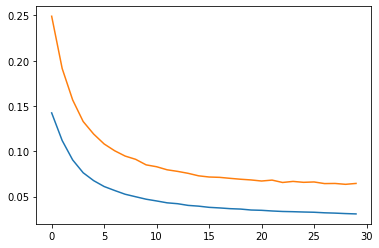

In [34]:
X_train = train_df['sentence'].values
y_train = bert_logits
y_real = train_df['label'].values

distiller = BILSTMDistilledStudentTrainer(distillation_settings)

model, vocab = distiller.train(X_train, y_train, y_real, ROOT_DATA_PATH)